### 1. Setup and Configuration
Imports necessary libraries, defines file paths, sets the time window for the full year of 2018, and defines a helper class to handle sparse matrices in the pipeline.


In [2]:
from pathlib import Path
from typing import List, Tuple, Dict

import json
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import joblib
import matplotlib.pyplot as plt

# -------------------------
# Input
# -------------------------
DATA_PATH = Path("bike_data_clean.parquet")
CLUSTERS_TO_MODEL = [0, 8]

# -------------------------
# Output
# -------------------------
ART_DIR = Path("artifacts_mlp")
PRED_DIR = Path("preds_mlp")
ART_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# Time split
# -------------------------
VAL_START  = pd.to_datetime("2018-11-01")
VAL_END    = pd.to_datetime("2018-12-01")  # exclusive
TEST_START = pd.to_datetime("2018-12-01")  # test = Dec onward

# Full-year window (CRITICAL FIX)
START_TIME = pd.Timestamp("2018-01-01 00:00:00")
END_TIME   = pd.Timestamp("2018-12-31 23:00:00")

# Feature columns
NUM_FEATS = ['lag_1','lag_24','lag_168','rmean_3h','rmean_24h']
CAT_FEATS = ['hour','weekday','gmm20_cluster']
FEATURES = NUM_FEATS + CAT_FEATS

EPS = 1e-6

class DenseTransformer(TransformerMixin, BaseEstimator):
    """MLPRegressor doesn't like sparse matrices in many sklearn versions."""
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        try:
            return X.toarray()
        except Exception:
            return X

assert DATA_PATH.exists(), f"Missing {DATA_PATH}"
print("[OK] Config set.")
print("[INFO] Window:", START_TIME, "to", END_TIME)
print("[INFO] Val:", VAL_START, "to", VAL_END, "(exclusive)")
print("[INFO] Test from:", TEST_START)


[OK] Config set.
[INFO] Window: 2018-01-01 00:00:00 to 2018-12-31 23:00:00
[INFO] Val: 2018-11-01 00:00:00 to 2018-12-01 00:00:00 (exclusive)
[INFO] Test from: 2018-12-01 00:00:00


### 2. Data Aggregation
Aggregating raw trip data into hourly time series (pickups and dropoffs) for the specified clusters, ensuring a continuous time grid including hours with zero activity.


In [3]:
def build_hourly_series_for_clusters(
    df: pd.DataFrame,
    clusters: List[int],
    start_time: pd.Timestamp,
    end_time: pd.Timestamp,
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    clusters = [int(c) for c in clusters]
    clusters_set = set(clusters)

    needed_cols = ["gmm20_cluster","end_gmm20_cluster","start_date","start_hour","stop_date","stop_hour"]
    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in df: {missing}")

    start_ts = pd.to_datetime(df["start_date"]).dt.normalize() + pd.to_timedelta(df["start_hour"], unit="h")
    stop_ts  = pd.to_datetime(df["stop_date"]).dt.normalize()  + pd.to_timedelta(df["stop_hour"], unit="h")

    pick_mask = df["gmm20_cluster"].isin(clusters_set)
    pick_tbl = pd.DataFrame({
        "gmm20_cluster": df.loc[pick_mask, "gmm20_cluster"].astype("int16").values,
        "timestamp": pd.to_datetime(start_ts.loc[pick_mask]).dt.floor("H").values
    })
    pick_tbl = pick_tbl[(pick_tbl["timestamp"] >= start_time) & (pick_tbl["timestamp"] <= end_time)]
    agg_pick = pick_tbl.groupby(["gmm20_cluster","timestamp"]).size().rename("pickups").reset_index()

    drop_mask = df["end_gmm20_cluster"].isin(clusters_set)
    drop_tbl = pd.DataFrame({
        "gmm20_cluster": df.loc[drop_mask, "end_gmm20_cluster"].astype("int16").values,
        "timestamp": pd.to_datetime(stop_ts.loc[drop_mask]).dt.floor("H").values
    })
    drop_tbl = drop_tbl[(drop_tbl["timestamp"] >= start_time) & (drop_tbl["timestamp"] <= end_time)]
    agg_drop = drop_tbl.groupby(["gmm20_cluster","timestamp"]).size().rename("dropoffs").reset_index()

    hours = pd.date_range(start_time, end_time, freq="H")
    grid = pd.MultiIndex.from_product([clusters, hours], names=["gmm20_cluster","timestamp"]).to_frame(index=False)

    ts_pick = grid.merge(agg_pick, on=["gmm20_cluster","timestamp"], how="left")
    ts_pick["pickups"] = ts_pick["pickups"].fillna(0).astype("float32")

    ts_drop = grid.merge(agg_drop, on=["gmm20_cluster","timestamp"], how="left")
    ts_drop["dropoffs"] = ts_drop["dropoffs"].fillna(0).astype("float32")

    return ts_pick, ts_drop


### 3. Feature Engineering
Generating lag features (1h, 24h, 1 week) and rolling means to capture temporal dependencies and seasonality in the data.

In [4]:
def add_lags_rolls(df_in: pd.DataFrame, value_col: str, lags=(1, 24, 168)) -> pd.DataFrame:
    df = df_in.sort_values(["gmm20_cluster", "timestamp"]).copy()

    g = df.groupby("gmm20_cluster")[value_col]

    for lag in lags:
        df[f"lag_{lag}"] = g.shift(lag)

    shifted = g.shift(1)
    df["rmean_3h"]  = shifted.groupby(df["gmm20_cluster"]).rolling(3,  min_periods=3).mean().reset_index(level=0, drop=True)
    df["rmean_24h"] = shifted.groupby(df["gmm20_cluster"]).rolling(24, min_periods=24).mean().reset_index(level=0, drop=True)

    df["hour"] = df["timestamp"].dt.hour.astype("int8")
    df["weekday"] = df["timestamp"].dt.weekday.astype("int8")

    df["y"] = df[value_col].astype("float32")
    return df


def _unique_cols(cols: List[str]) -> List[str]:
    seen = set()
    out = []
    for c in cols:
        if c not in seen:
            out.append(c)
            seen.add(c)
    return out


def make_feature_table(ts_pick: pd.DataFrame, ts_drop: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    pick_feat = add_lags_rolls(ts_pick, "pickups", lags=(1, 24, 168)).dropna().reset_index(drop=True)
    drop_feat = add_lags_rolls(ts_drop, "dropoffs", lags=(1, 24, 168)).dropna().reset_index(drop=True)

    desired_cols = _unique_cols(["timestamp"] + FEATURES + ["y"])

    missing_p = [c for c in desired_cols if c not in pick_feat.columns]
    missing_d = [c for c in desired_cols if c not in drop_feat.columns]
    if missing_p:
        raise ValueError(f"Pick feature table missing columns: {missing_p}")
    if missing_d:
        raise ValueError(f"Drop feature table missing columns: {missing_d}")

    pick_feat = pick_feat[desired_cols].copy()
    drop_feat = drop_feat[desired_cols].copy()

    if not pick_feat.columns.is_unique or not drop_feat.columns.is_unique:
        raise ValueError("Feature tables still have duplicate column names.")

    return pick_feat, drop_feat


### 4. Data Splitting
Splitting the time series data into Train (Jan-Oct), Validation (Nov), and Test (Dec) sets based on timestamps.

In [5]:
def split_blocks(ts: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train = ts[ts["timestamp"] < VAL_START].copy()
    val   = ts[(ts["timestamp"] >= VAL_START) & (ts["timestamp"] < VAL_END)].copy()
    test  = ts[ts["timestamp"] >= TEST_START].copy()
    return train, val, test


### 5. Model Architecture
Defining the MLP (Multi-Layer Perceptron) pipeline, including scaling, one-hot encoding, and a log-transformation of the target variable to handle count data distribution.

In [6]:
def make_mlp_model(random_state: int = 42) -> TransformedTargetRegressor:
    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), NUM_FEATS),
            ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_FEATS),
        ],
        remainder="drop",
        sparse_threshold=0.3,
    )

    # Slightly smaller + more regularization (now that data is larger this is safe)
    mlp = MLPRegressor(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        solver="adam",
        alpha=1e-3,
        learning_rate="adaptive",
        learning_rate_init=2e-3,
        batch_size=512,
        max_iter=800,
        early_stopping=False,  # avoid random internal split for time series
        random_state=random_state,
        shuffle=True,
    )

    pipe = Pipeline(steps=[
        ("pre", pre),
        ("dense", DenseTransformer()),
        ("mlp", mlp),
    ])

    # Log-transform the target (counts)
    model = TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1,
        check_inverse=False,
    )
    return model


def fit_model(model, train_df: pd.DataFrame):
    model.fit(train_df[FEATURES], train_df["y"].values)
    return model


def predict_nonneg(model, pred_df: pd.DataFrame) -> np.ndarray:
    pred = model.predict(pred_df[FEATURES]).astype("float32")
    return np.clip(pred, 0.0, None)


### 6. Output Formatting
Helper function to merge model predictions with ground truth data into a standardized DataFrame format for analysis.

In [7]:
def to_output_df(
    cluster_id: int,
    split_name: str,
    val_pick: pd.DataFrame,
    val_drop: pd.DataFrame,
    pred_pick: np.ndarray,
    pred_drop: np.ndarray,
) -> pd.DataFrame:
    # inner join on timestamp/hour for safety
    a = val_pick[["timestamp", "hour", "y"]].rename(columns={"y": "y_true_pickups"})
    b = val_drop[["timestamp", "hour", "y"]].rename(columns={"y": "y_true_dropoffs"})
    out = a.merge(b, on=["timestamp", "hour"], how="inner")

    out["y_pred_mlp_pickups"] = pred_pick[:len(out)]
    out["y_pred_mlp_dropoffs"] = pred_drop[:len(out)]

    out["date"] = pd.to_datetime(out["timestamp"]).dt.normalize()
    out["cluster_id"] = int(cluster_id)
    out["split"] = split_name

    return out[[
        "date","hour","cluster_id","split",
        "y_true_pickups","y_pred_mlp_pickups",
        "y_true_dropoffs","y_pred_mlp_dropoffs",
    ]]


### 7. Training and Execution Loop
Iterates through each cluster to:
1. Prepare specific features.
2. Train separate MLP models for pickups and dropoffs.
3. Save predictions and model artifacts for later use.

In [8]:
needed_cols = ["gmm20_cluster","end_gmm20_cluster","start_date","start_hour","stop_date","stop_hour"]
df = pd.read_parquet(DATA_PATH, columns=needed_cols)
print("[INFO] Loaded df:", df.shape)

clusters_set = set(CLUSTERS_TO_MODEL)
mask = df["gmm20_cluster"].isin(clusters_set) | df["end_gmm20_cluster"].isin(clusters_set)
df = df.loc[mask].copy()
print("[INFO] Filtered df:", df.shape)

ts_pick, ts_drop = build_hourly_series_for_clusters(df, CLUSTERS_TO_MODEL, START_TIME, END_TIME)
pick_feat_all, drop_feat_all = make_feature_table(ts_pick, ts_drop)
print("[INFO] pick_feat_all:", pick_feat_all.shape, "drop_feat_all:", drop_feat_all.shape)

all_out_rows = []

for cid in CLUSTERS_TO_MODEL:
    print("\n" + "="*80)
    print(f"[CLUSTER {cid}] training hourly MLP on Ridge-style features...")

    pick_c = pick_feat_all[pick_feat_all["gmm20_cluster"] == cid].copy()
    drop_c = drop_feat_all[drop_feat_all["gmm20_cluster"] == cid].copy()

    tr_p, va_p, te_p = split_blocks(pick_c)
    tr_d, va_d, te_d = split_blocks(drop_c)

    print(f"[CLUSTER {cid}] train/val/test sizes (pick) = {len(tr_p)}/{len(va_p)}/{len(te_p)}")
    print(f"[CLUSTER {cid}] train/val/test sizes (drop) = {len(tr_d)}/{len(va_d)}/{len(te_d)}")

    # ---- Pickups model (fit once) ----
    model_p = make_mlp_model(random_state=42)
    fit_model(model_p, tr_p)
    loss_curve_p = model_p.regressor_.named_steps["mlp"].loss_curve_
    pred_val_p  = predict_nonneg(model_p, va_p)
    pred_test_p = predict_nonneg(model_p, te_p) if len(te_p) else np.array([], dtype="float32")

    # ---- Dropoffs model (fit once) ----
    model_d = make_mlp_model(random_state=42)
    fit_model(model_d, tr_d)
    loss_curve_d = model_d.regressor_.named_steps["mlp"].loss_curve_
    pred_val_d  = predict_nonneg(model_d, va_d)
    pred_test_d = predict_nonneg(model_d, te_d) if len(te_d) else np.array([], dtype="float32")

    df_val_out = to_output_df(cid, "val", va_p, va_d, pred_val_p, pred_val_d)
    all_out_rows.append(df_val_out)

    if len(te_p) and len(te_d):
        df_test_out = to_output_df(cid, "test", te_p, te_d, pred_test_p, pred_test_d)
        all_out_rows.append(df_test_out)

    # Save predictions per cluster
    df_out = pd.concat([df_val_out] + ([df_test_out] if len(te_p) and len(te_d) else []), ignore_index=True)
    out_path = PRED_DIR / f"mlp_cluster_{cid}_preds.parquet"
    df_out.to_parquet(out_path, index=False)
    print(f"[CLUSTER {cid}] saved predictions -> {out_path}")

    # Save artifacts
    artifact = {
        "cluster_id": int(cid),
        "model_pickups": model_p,
        "model_dropoffs": model_d,
        "features": FEATURES,
        "num_feats": NUM_FEATS,
        "cat_feats": CAT_FEATS,
        "loss_curve_pickups": loss_curve_p,
        "loss_curve_dropoffs": loss_curve_d,
        "split_info": {
            "start_time": str(START_TIME),
            "val_start": str(VAL_START),
            "val_end_exclusive": str(VAL_END),
            "test_start": str(TEST_START),
            "end_time": str(END_TIME),
        }
    }
    art_path = ART_DIR / f"mlp_cluster_{cid}.joblib"
    joblib.dump(artifact, art_path)
    print(f"[CLUSTER {cid}] saved artifact -> {art_path}")

print("\n[OK] Finished all clusters.")


[INFO] Loaded df: (17531179, 6)
[INFO] Filtered df: (3935878, 6)


C:\Users\andre\AppData\Local\Temp\ipykernel_12568\3274892231.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.to_datetime(start_ts.loc[pick_mask]).dt.floor("H").values
C:\Users\andre\AppData\Local\Temp\ipykernel_12568\3274892231.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.to_datetime(stop_ts.loc[drop_mask]).dt.floor("H").values
C:\Users\andre\AppData\Local\Temp\ipykernel_12568\3274892231.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start_time, end_time, freq="H")


[INFO] pick_feat_all: (17184, 10) drop_feat_all: (17184, 10)

[CLUSTER 0] training hourly MLP on Ridge-style features...
[CLUSTER 0] train/val/test sizes (pick) = 7128/720/744
[CLUSTER 0] train/val/test sizes (drop) = 7128/720/744
[CLUSTER 0] saved predictions -> preds_mlp\mlp_cluster_0_preds.parquet
[CLUSTER 0] saved artifact -> artifacts_mlp\mlp_cluster_0.joblib

[CLUSTER 8] training hourly MLP on Ridge-style features...
[CLUSTER 8] train/val/test sizes (pick) = 7128/720/744
[CLUSTER 8] train/val/test sizes (drop) = 7128/720/744
[CLUSTER 8] saved predictions -> preds_mlp\mlp_cluster_8_preds.parquet
[CLUSTER 8] saved artifact -> artifacts_mlp\mlp_cluster_8.joblib

[OK] Finished all clusters.


### 8. Global Evaluation and Weighting
Calculates the RMSE for the test period (December) and computes a "general weight" for this model to be used in the final ensemble.

In [9]:
out_all = pd.concat(all_out_rows, ignore_index=True)

test_all = out_all[out_all["split"] == "test"].copy()
assert len(test_all), "No test rows found (expected December). Check END_TIME / TEST_START."

rmse_pick_test = float(np.sqrt(mean_squared_error(test_all["y_true_pickups"], test_all["y_pred_mlp_pickups"])))
rmse_drop_test = float(np.sqrt(mean_squared_error(test_all["y_true_dropoffs"], test_all["y_pred_mlp_dropoffs"])))
rmse_mean_test = 0.5 * (rmse_pick_test + rmse_drop_test)

# Optional sanity baseline: "predict tomorrow = yesterday" (lag_24)
# Works because the true data is hourly aligned and has daily seasonality.
test_all_sorted = test_all.sort_values(["cluster_id", "date", "hour"]).copy()
test_all_sorted["baseline_pick"] = test_all_sorted.groupby("cluster_id")["y_true_pickups"].shift(24)
test_all_sorted["baseline_drop"] = test_all_sorted.groupby("cluster_id")["y_true_dropoffs"].shift(24)
base_ok = test_all_sorted.dropna(subset=["baseline_pick","baseline_drop"])

rmse_pick_base = float(np.sqrt(mean_squared_error(base_ok["y_true_pickups"], base_ok["baseline_pick"])))
rmse_drop_base = float(np.sqrt(mean_squared_error(base_ok["y_true_dropoffs"], base_ok["baseline_drop"])))
rmse_mean_base = 0.5 * (rmse_pick_base + rmse_drop_base)

general_weight_raw = 1.0 / (rmse_mean_test + EPS)

weight_payload = {
    "model": "mlp_hourly_ridge_features_log1p",
    "clusters": CLUSTERS_TO_MODEL,
    "test_period": {"start_inclusive": str(TEST_START.date()), "end_inclusive": str(END_TIME.date())},
    "rmse_pickups_test": rmse_pick_test,
    "rmse_dropoffs_test": rmse_drop_test,
    "general_rmse_test": rmse_mean_test,
    "rmse_pickups_baseline_lag24_test": rmse_pick_base,
    "rmse_dropoffs_baseline_lag24_test": rmse_drop_base,
    "general_rmse_baseline_lag24_test": rmse_mean_base,
    "general_weight_raw": general_weight_raw,
    "notes": "CRITICAL FIX: trained on full 2018 (not just 10-day buffer). log1p target. Test RMSE is December."
}

weight_path = ART_DIR / "mlp_general_weight_test_december.json"
weight_path.write_text(json.dumps(weight_payload, indent=2))
print("[OK] Saved:", weight_path)
print(json.dumps(weight_payload, indent=2))


[OK] Saved: artifacts_mlp\mlp_general_weight_test_december.json
{
  "model": "mlp_hourly_ridge_features_log1p",
  "clusters": [
    0,
    8
  ],
  "test_period": {
    "start_inclusive": "2018-12-01",
    "end_inclusive": "2018-12-31"
  },
  "rmse_pickups_test": 28.86658477783203,
  "rmse_dropoffs_test": 27.873790740966797,
  "general_rmse_test": 28.370187759399414,
  "rmse_pickups_baseline_lag24_test": 88.60916900634766,
  "rmse_dropoffs_baseline_lag24_test": 83.24129486083984,
  "general_rmse_baseline_lag24_test": 85.92523193359375,
  "general_weight_raw": 0.03524826741481186,
  "notes": "CRITICAL FIX: trained on full 2018 (not just 10-day buffer). log1p target. Test RMSE is December."
}


In [10]:
def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def load_all_cluster_outputs(clusters, pred_dir: Path):
    dfs = []
    for cid in clusters:
        p = pred_dir / f"mlp_cluster_{cid}_preds.parquet"
        dfs.append(pd.read_parquet(p))
    out = pd.concat(dfs, ignore_index=True)
    out["timestamp"] = pd.to_datetime(out["date"]) + pd.to_timedelta(out["hour"], unit="h")
    out["month"] = out["timestamp"].dt.to_period("M").astype(str)
    return out

def compute_required_bikes_series(Yp: np.ndarray, Yd: np.ndarray) -> np.ndarray:
    required = []
    for pickups, dropoffs in zip(Yp, Yd):
        net = dropoffs - pickups
        cum_net = np.cumsum(net)
        min_cum = float(cum_net.min())
        req = max(0.0, -min_cum)
        required.append(req)
    return np.array(required, dtype="float32")

def daily_required_from_hourly_df(df_hourly: pd.DataFrame, true_col_p, true_col_d, pred_col_p, pred_col_d):
    """
    Returns one row per day with required bikes (true/pred),
    computed from the 24-hour pickup/dropoff trajectories.
    """
    dfh = df_hourly.copy()
    dfh["day"] = dfh["timestamp"].dt.normalize()

    days = []
    for day, g in dfh.groupby("day"):
        g = g.sort_values("hour")
        if len(g) < 24:   # if incomplete day exists, skip
            continue
        Yp_true = g[true_col_p].values.reshape(1, -1)
        Yd_true = g[true_col_d].values.reshape(1, -1)
        Yp_pred = g[pred_col_p].values.reshape(1, -1)
        Yd_pred = g[pred_col_d].values.reshape(1, -1)

        req_true = compute_required_bikes_series(Yp_true, Yd_true)[0]
        req_pred = compute_required_bikes_series(Yp_pred, Yd_pred)[0]
        days.append((day, req_true, req_pred))

    return pd.DataFrame(days, columns=["day", "required_true", "required_pred"])


### 10. Performance Dashboard
The following cell simply generates a comprehensive visualization for each cluster, showing loss curves, weekly predictions, required bike estimations, and daily RMSE metrics.

C:\Users\andre\AppData\Local\Temp\ipykernel_12568\380540000.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


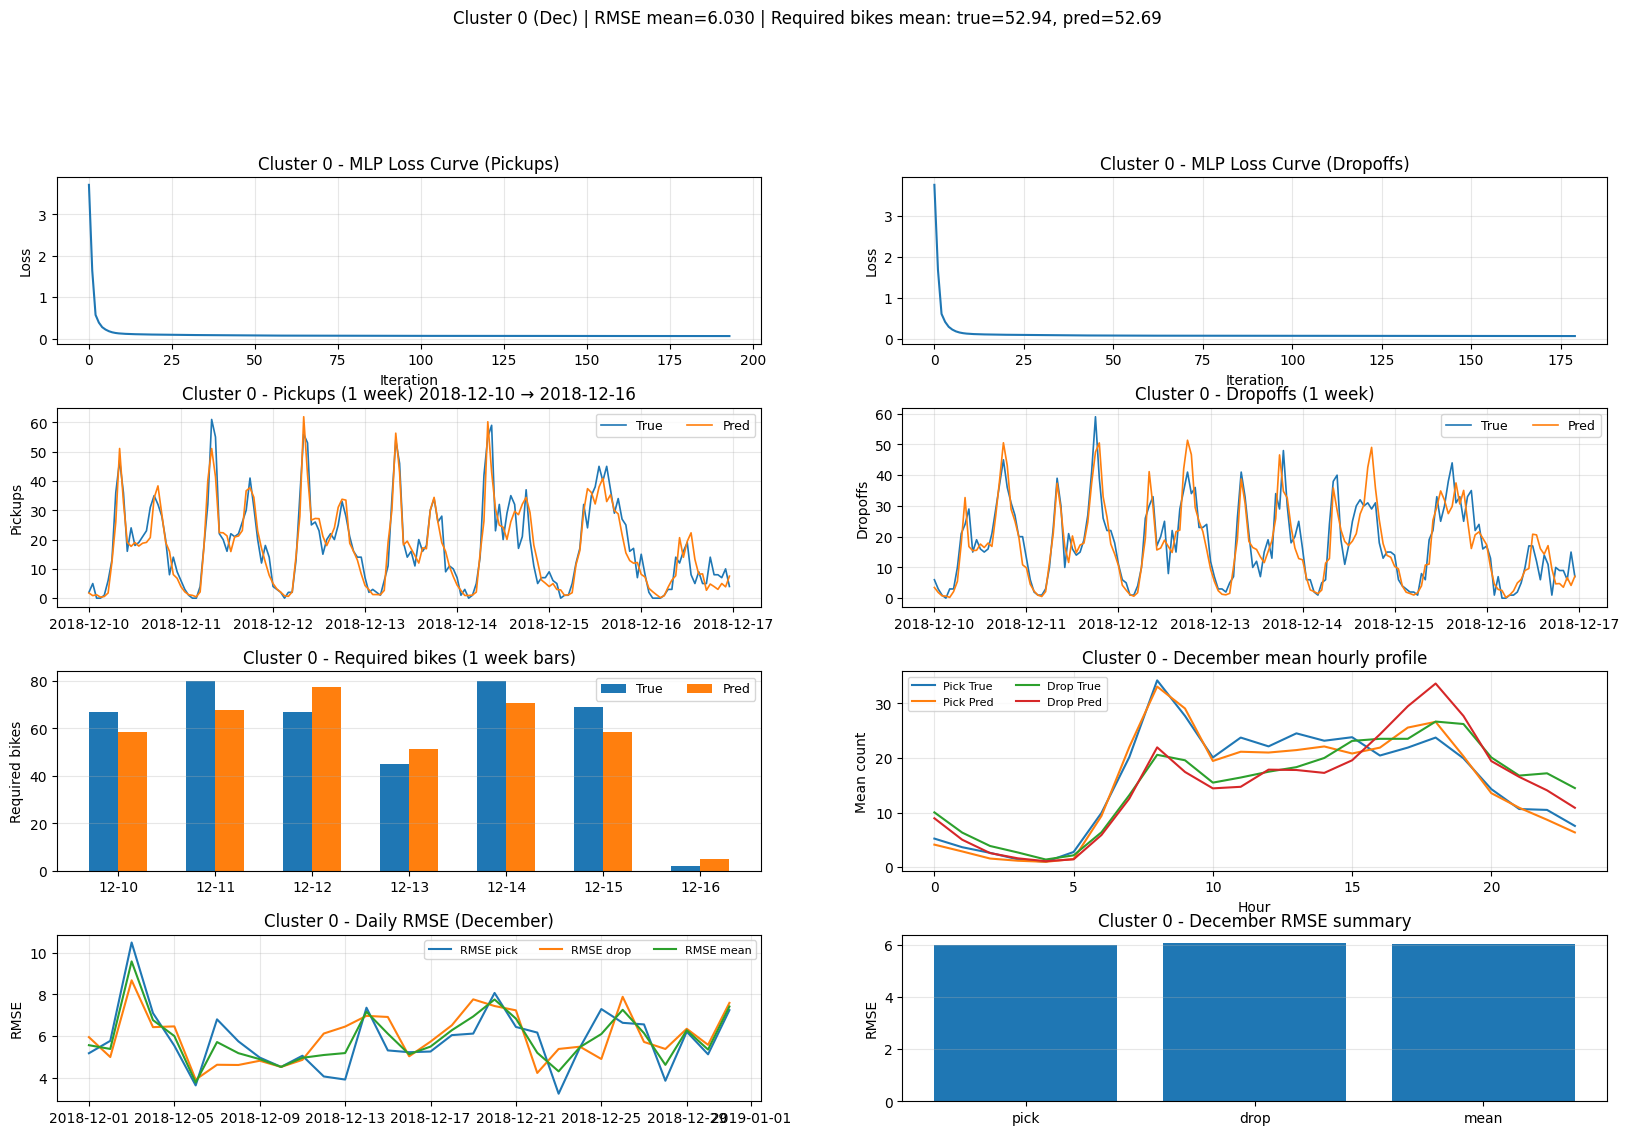

C:\Users\andre\AppData\Local\Temp\ipykernel_12568\380540000.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


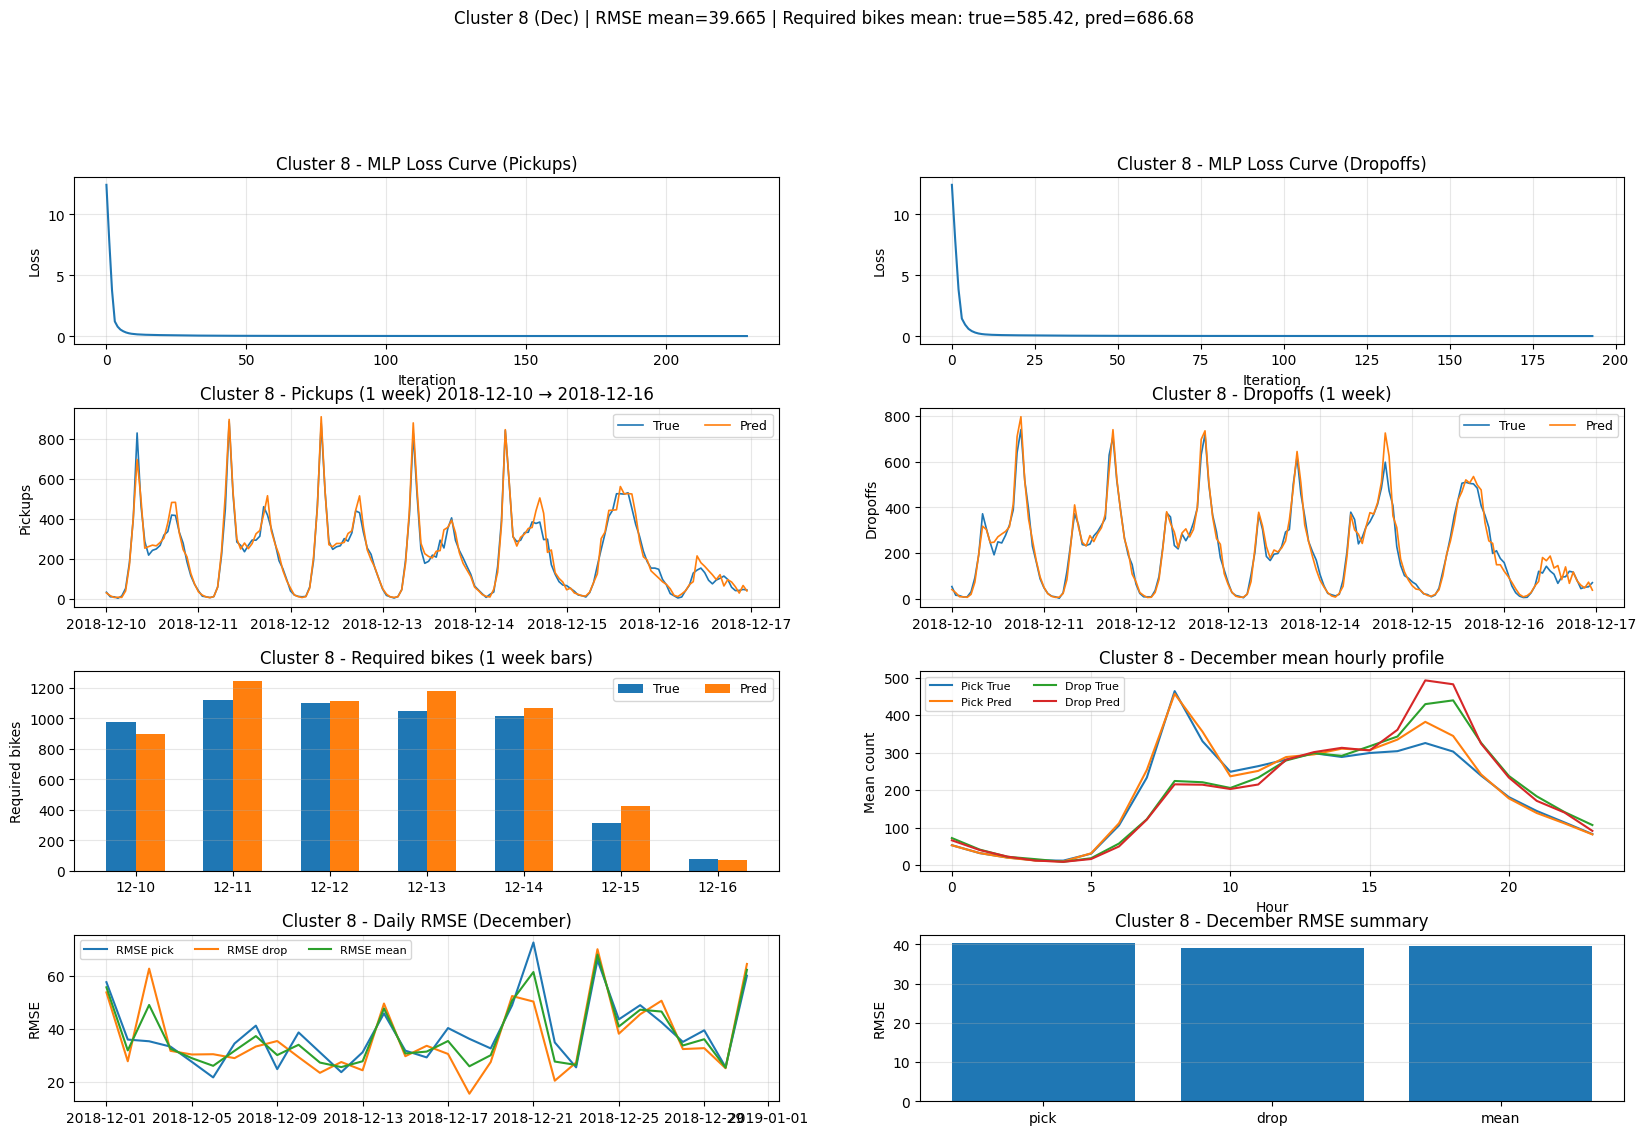

In [11]:
# Load predictions
out_all = load_all_cluster_outputs(CLUSTERS_TO_MODEL, PRED_DIR)

DEC_START = pd.Timestamp("2018-12-01")
DEC_END   = pd.Timestamp("2018-12-31 23:00:00")

# Pick a 1-week window in December (change if you want)
WEEK_START = pd.Timestamp("2018-12-10 00:00:00")
WEEK_END   = WEEK_START + pd.Timedelta(days=7)  # exclusive

TRUE_P = "y_true_pickups"
PRED_P = "y_pred_mlp_pickups"
TRUE_D = "y_true_dropoffs"
PRED_D = "y_pred_mlp_dropoffs"

for cid in CLUSTERS_TO_MODEL:
    dfc = out_all[(out_all["cluster_id"] == cid) & (out_all["split"] == "test")].copy()
    dfc = dfc[(dfc["timestamp"] >= DEC_START) & (dfc["timestamp"] <= DEC_END)]
    dfc = dfc.sort_values("timestamp")

    if dfc.empty:
        print(f"[WARN] No December test data for cluster {cid}")
        continue

    # ----- Load loss curves from artifacts -----
    art_path = ART_DIR / f"mlp_cluster_{cid}.joblib"
    artifact = joblib.load(art_path)
    loss_p = artifact.get("loss_curve_pickups", None)
    loss_d = artifact.get("loss_curve_dropoffs", None)

    # ----- 1-week window -----
    week = dfc[(dfc["timestamp"] >= WEEK_START) & (dfc["timestamp"] < WEEK_END)].copy()

    # ----- Monthly mean hourly profiles (Dec) -----
    mean_hour = (
        dfc.groupby("hour")[[TRUE_P, PRED_P, TRUE_D, PRED_D]]
        .mean()
        .reset_index()
        .sort_values("hour")
    )

    # ----- Required bikes daily (Dec) -----
    req_daily = daily_required_from_hourly_df(dfc, TRUE_P, TRUE_D, PRED_P, PRED_D)

    # Monthly mean required bikes (Dec)
    mean_req = req_daily[["required_true", "required_pred"]].mean()

    # ----- Daily RMSE (Dec) -----
    # pickup & drop computed on 24 hourly points per day
    dfc["day"] = dfc["timestamp"].dt.normalize()
    daily_metrics = []
    for day, g in dfc.groupby("day"):
        g = g.sort_values("hour")
        if len(g) < 24:
            continue
        rp = rmse(g[TRUE_P].values, g[PRED_P].values)
        rd = rmse(g[TRUE_D].values, g[PRED_D].values)
        daily_metrics.append((day, rp, rd, 0.5*(rp+rd)))
    daily_metrics = pd.DataFrame(daily_metrics, columns=["day", "rmse_pickups", "rmse_dropoffs", "rmse_mean"])

    # overall Dec RMSE
    rmse_pick = rmse(dfc[TRUE_P].values, dfc[PRED_P].values)
    rmse_drop = rmse(dfc[TRUE_D].values, dfc[PRED_D].values)
    rmse_avg  = 0.5*(rmse_pick + rmse_drop)

    # =========================
    # Compact plotting layout
    # =========================
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(4, 2, height_ratios=[1.0, 1.2, 1.2, 1.0], hspace=0.35, wspace=0.2)

    # (1) Loss curves
    ax = fig.add_subplot(gs[0, 0])
    if loss_p is not None:
        ax.plot(loss_p)
        ax.set_title(f"Cluster {cid} - MLP Loss Curve (Pickups)")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "No loss curve saved", ha="center", va="center")
        ax.set_axis_off()

    ax = fig.add_subplot(gs[0, 1])
    if loss_d is not None:
        ax.plot(loss_d)
        ax.set_title(f"Cluster {cid} - MLP Loss Curve (Dropoffs)")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "No loss curve saved", ha="center", va="center")
        ax.set_axis_off()

    # (2) One-week pickups (hourly timeline)
    ax = fig.add_subplot(gs[1, 0])
    if not week.empty:
        ax.plot(week["timestamp"], week[TRUE_P], label="True", linewidth=1.2)
        ax.plot(week["timestamp"], week[PRED_P], label="Pred", linewidth=1.2)
        ax.set_title(f"Cluster {cid} - Pickups (1 week) {WEEK_START.date()} → {(WEEK_END - pd.Timedelta(hours=1)).date()}")
        ax.set_ylabel("Pickups")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=2, fontsize=9)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (3) One-week dropoffs (hourly timeline)
    ax = fig.add_subplot(gs[1, 1])
    if not week.empty:
        ax.plot(week["timestamp"], week[TRUE_D], label="True", linewidth=1.2)
        ax.plot(week["timestamp"], week[PRED_D], label="Pred", linewidth=1.2)
        ax.set_title(f"Cluster {cid} - Dropoffs (1 week)")
        ax.set_ylabel("Dropoffs")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=2, fontsize=9)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (4) Required bikes bars (first 7 days of that week, compact)
    ax = fig.add_subplot(gs[2, 0])
    if not week.empty:
        req_week = daily_required_from_hourly_df(week, TRUE_P, TRUE_D, PRED_P, PRED_D)
        req_week = req_week.sort_values("day").head(7)
        x = np.arange(len(req_week))
        ax.bar(x - 0.15, req_week["required_true"].values, width=0.3, label="True")
        ax.bar(x + 0.15, req_week["required_pred"].values, width=0.3, label="Pred")
        ax.set_xticks(x)
        ax.set_xticklabels(req_week["day"].dt.strftime("%m-%d").values, rotation=0)
        ax.set_title(f"Cluster {cid} - Required bikes (1 week bars)")
        ax.set_ylabel("Required bikes")
        ax.legend(ncol=2, fontsize=9)
        ax.grid(True, axis="y", alpha=0.3)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (5) December mean hourly profile pickups+dropoffs (compact)
    ax = fig.add_subplot(gs[2, 1])
    ax.plot(mean_hour["hour"], mean_hour[TRUE_P], label="Pick True")
    ax.plot(mean_hour["hour"], mean_hour[PRED_P], label="Pick Pred")
    ax.plot(mean_hour["hour"], mean_hour[TRUE_D], label="Drop True")
    ax.plot(mean_hour["hour"], mean_hour[PRED_D], label="Drop Pred")
    ax.set_title(f"Cluster {cid} - December mean hourly profile")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Mean count")
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=8)

    # (6) RMSE in test set (December): daily line + summary bars
    ax = fig.add_subplot(gs[3, 0])
    if not daily_metrics.empty:
        ax.plot(daily_metrics["day"], daily_metrics["rmse_pickups"], label="RMSE pick")
        ax.plot(daily_metrics["day"], daily_metrics["rmse_dropoffs"], label="RMSE drop")
        ax.plot(daily_metrics["day"], daily_metrics["rmse_mean"], label="RMSE mean")
        ax.set_title(f"Cluster {cid} - Daily RMSE (December)")
        ax.set_ylabel("RMSE")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=3, fontsize=8)
    else:
        ax.text(0.5, 0.5, "No daily metrics", ha="center", va="center")
        ax.set_axis_off()

    ax = fig.add_subplot(gs[3, 1])
    ax.bar(["pick", "drop", "mean"], [rmse_pick, rmse_drop, rmse_avg])
    ax.set_title(f"Cluster {cid} - December RMSE summary")
    ax.set_ylabel("RMSE")
    ax.grid(True, axis="y", alpha=0.3)

    # Add required bikes monthly mean as a tiny note
    fig.suptitle(
        f"Cluster {cid} (Dec) | RMSE mean={rmse_avg:.3f} | Required bikes mean: true={mean_req['required_true']:.2f}, pred={mean_req['required_pred']:.2f}",
        y=1.02,
        fontsize=12
    )

    plt.tight_layout()
    plt.show()


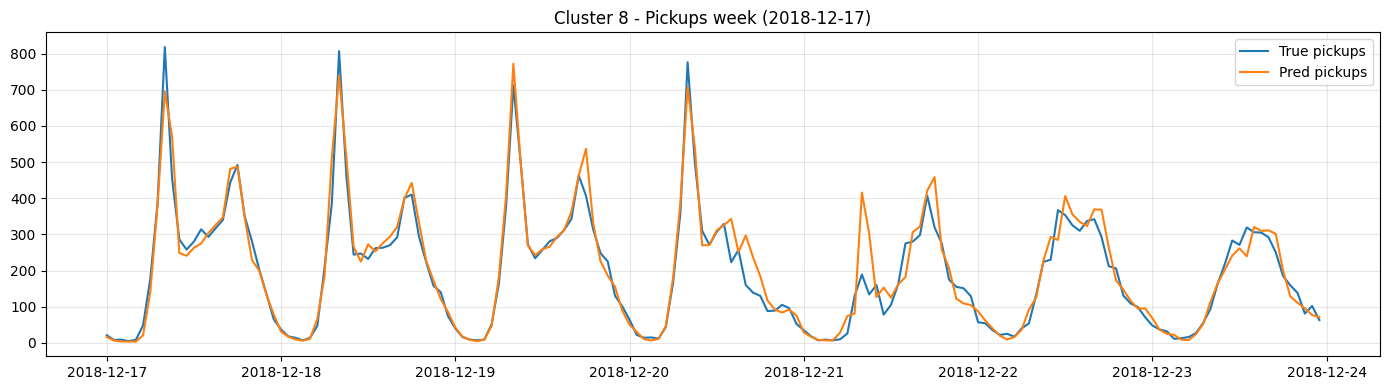

In [12]:
def plot_cluster_detail(out_all, cid, week_start="2018-12-10"):
    """Plot pickups over one week for a given cluster ID."""
    dfc = out_all[(out_all["cluster_id"] == cid) & (out_all["split"] == "test")].copy()
    dfc = dfc[(dfc["timestamp"] >= "2018-12-01") & (dfc["timestamp"] <= "2018-12-31 23:00:00")]
    dfc = dfc.sort_values("timestamp")
    week_start = pd.Timestamp(week_start)
    week_end = week_start + pd.Timedelta(days=7)
    week = dfc[(dfc["timestamp"] >= week_start) & (dfc["timestamp"] < week_end)].copy()

    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    ax.plot(week["timestamp"], week["y_true_pickups"], label="True pickups")
    ax.plot(week["timestamp"], week["y_pred_mlp_pickups"], label="Pred pickups")
    ax.set_title(f"Cluster {cid} - Pickups week ({week_start.date()})")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example:
plot_cluster_detail(out_all, 8, "2018-12-17")



GENERATING PLOTS FOR CLUSTER 0


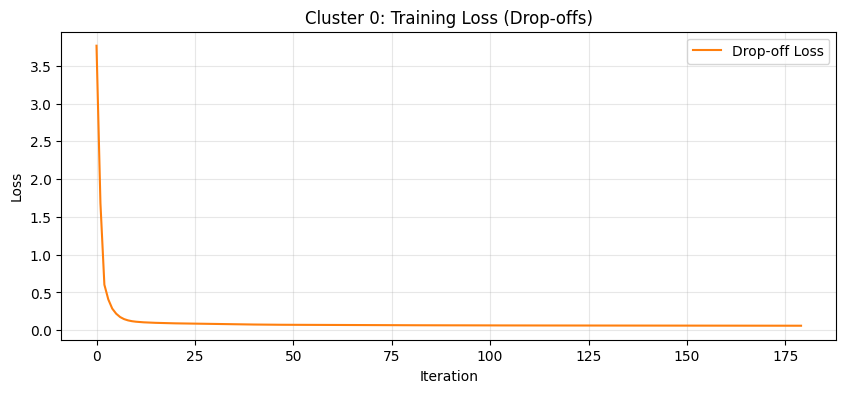

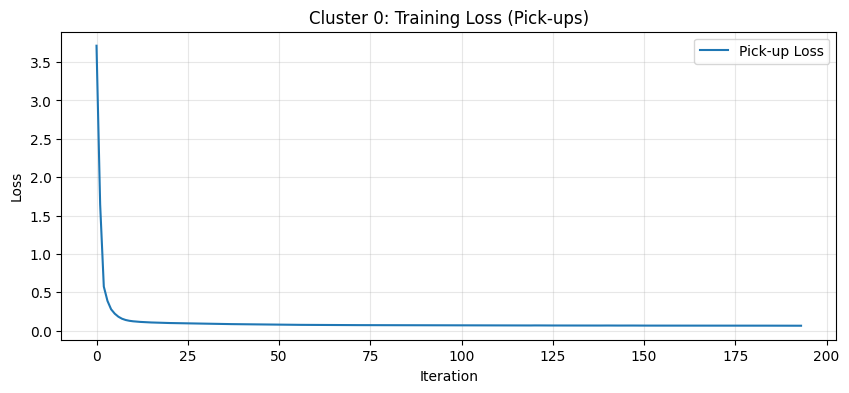

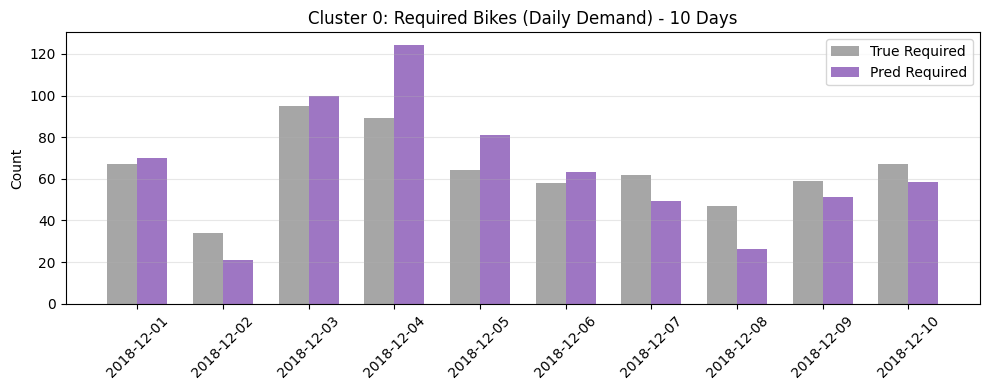


GENERATING PLOTS FOR CLUSTER 8


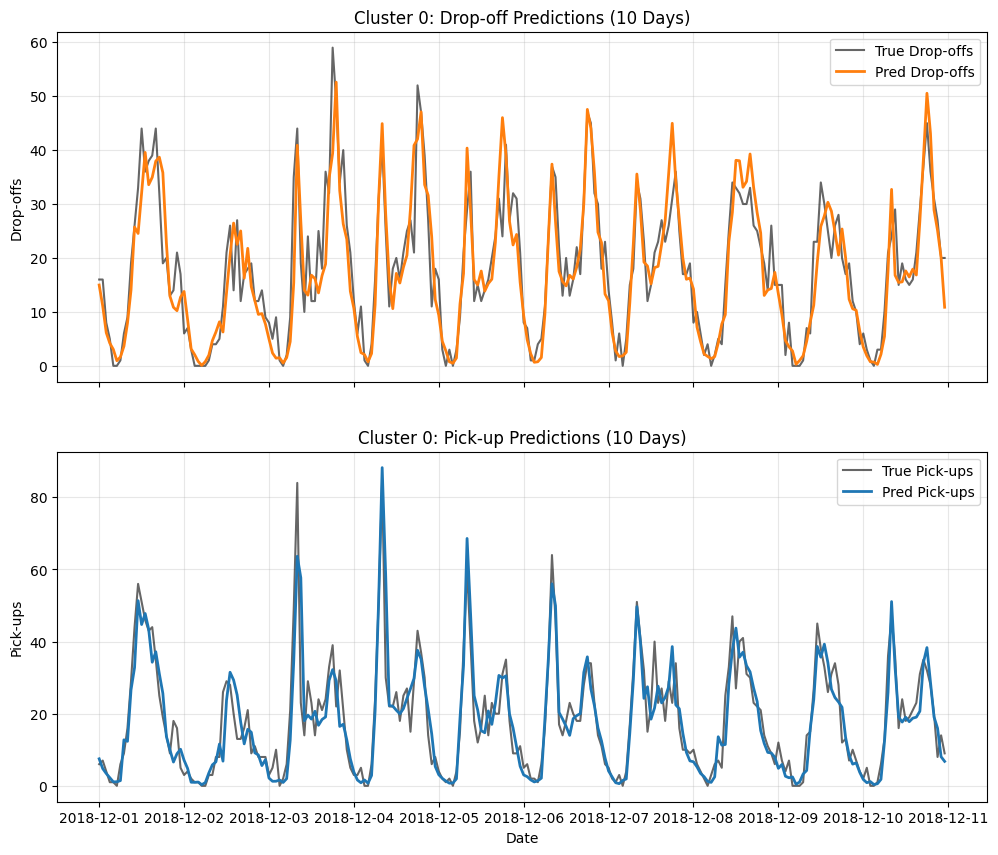

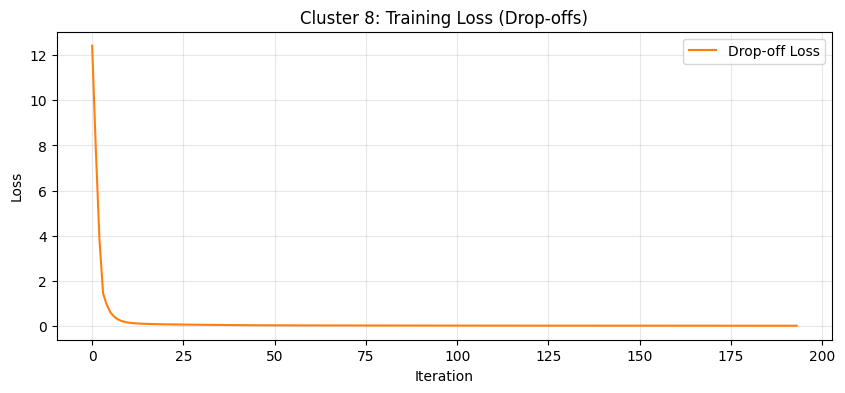

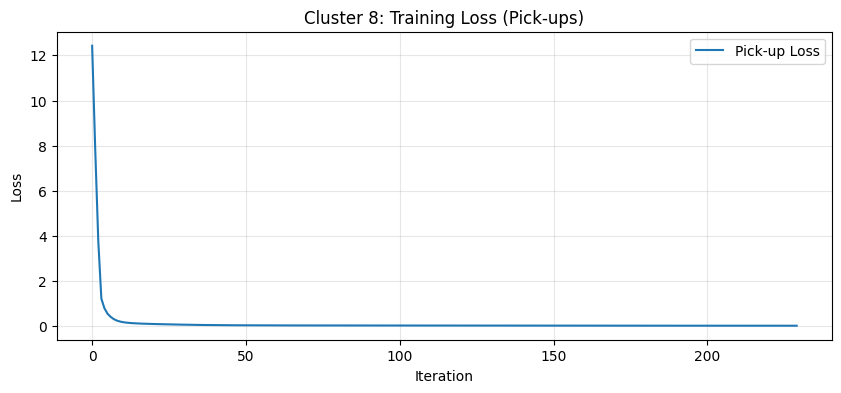

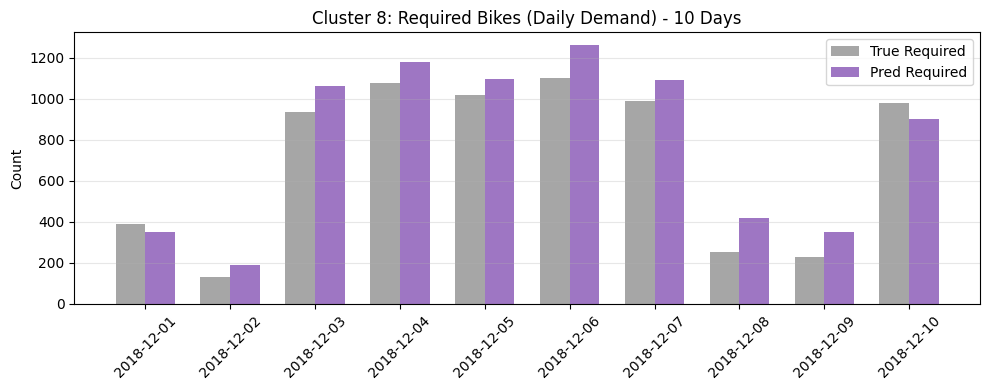

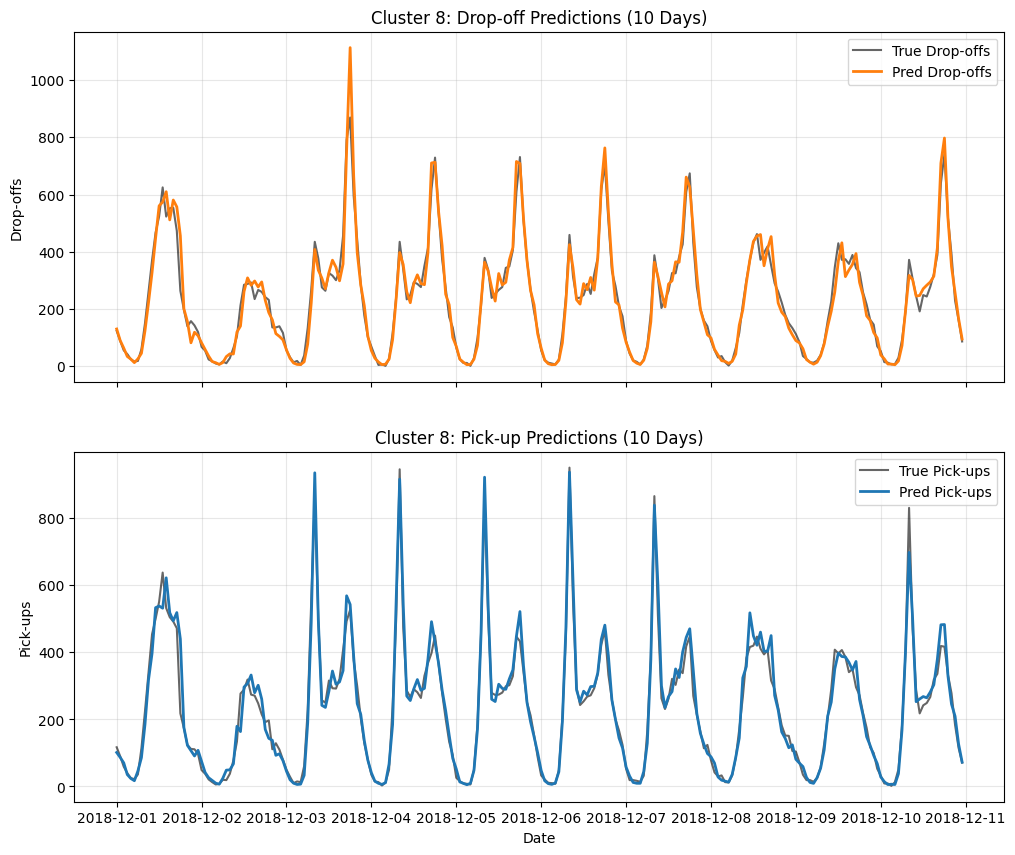

In [18]:
import matplotlib.dates as mdates

# Define the 10-day window for the time-series plots
PLOT_START = pd.Timestamp("2018-12-01")
PLOT_END   = PLOT_START + pd.Timedelta(days=10)

# Ensure data is loaded
out_all_analysis = load_all_cluster_outputs(CLUSTERS_TO_MODEL, PRED_DIR)

for cid in CLUSTERS_TO_MODEL:
    print(f"\n{'='*60}\nGENERATING PLOTS FOR CLUSTER {cid}\n{'='*60}")
    
    # --- Prepare Data ---
    # Filter for specific cluster and test split (December)
    dfc = out_all_analysis[(out_all_analysis["cluster_id"] == cid) & (out_all_analysis["split"] == "test")].copy()
    dfc = dfc.sort_values("timestamp")
    
    # Filter for the 10-day window
    mask_window = (dfc["timestamp"] >= PLOT_START) & (dfc["timestamp"] < PLOT_END)
    df_window = dfc[mask_window].copy()
    
    if df_window.empty:
        print(f"No data found for Cluster {cid} in window {PLOT_START} to {PLOT_END}")
        continue

    # Load artifacts for loss curves
    art_path = ART_DIR / f"mlp_cluster_{cid}.joblib"
    artifact = joblib.load(art_path)
    loss_p = artifact.get("loss_curve_pickups", [])
    loss_d = artifact.get("loss_curve_dropoffs", [])

    # Calculate required bikes for the window
    req_daily = daily_required_from_hourly_df(
        df_window, 
        "y_true_pickups", "y_true_dropoffs", 
        "y_pred_mlp_pickups", "y_pred_mlp_dropoffs"
    )

    # --- Generate 5 Separate Plots ---

    # 1. Training Loss - Drop-offs
    plt.figure(figsize=(10, 4))
    plt.plot(loss_d, color='tab:orange', label='Drop-off Loss')
    plt.title(f"Cluster {cid}: Training Loss (Drop-offs)")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 2. Training Loss - Pick-ups
    plt.figure(figsize=(10, 4))
    plt.plot(loss_p, color='tab:blue', label='Pick-up Loss')
    plt.title(f"Cluster {cid}: Training Loss (Pick-ups)")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. Demand Prediction Bar Plot (Required Bikes)
    plt.figure(figsize=(10, 4))
    x_indexes = np.arange(len(req_daily))
    width = 0.35
    plt.bar(x_indexes - width/2, req_daily["required_true"], width, label='True Required', color='grey', alpha=0.7)
    plt.bar(x_indexes + width/2, req_daily["required_pred"], width, label='Pred Required', color='tab:purple', alpha=0.9)
    plt.xticks(x_indexes, req_daily["day"].dt.strftime('%Y-%m-%d'), rotation=45)
    plt.title(f"Cluster {cid}: Required Bikes (Daily Demand) - 10 Days")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

        # 4. Combined 10 Days Prediction (Drop-offs and Pick-ups)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Subplot 1: Drop-offs
    ax1.plot(df_window["timestamp"], df_window["y_true_dropoffs"], label="True Drop-offs", color='black', alpha=0.6)
    ax1.plot(df_window["timestamp"], df_window["y_pred_mlp_dropoffs"], label="Pred Drop-offs", color='tab:orange', linewidth=2)
    ax1.set_title(f"Cluster {cid}: Drop-off Predictions (10 Days)")
    ax1.set_ylabel("Drop-offs")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Pick-ups
    ax2.plot(df_window["timestamp"], df_window["y_true_pickups"], label="True Pick-ups", color='black', alpha=0.6)
    ax2.plot(df_window["timestamp"], df_window["y_pred_mlp_pickups"], label="Pred Pick-ups", color='tab:blue', linewidth=2)
    ax2.set_title(f"Cluster {cid}: Pick-up Predictions (10 Days)")
    ax2.set_ylabel("Pick-ups")
    ax2.set_xlabel("Date")
    ax2.legend()
    ax2.grid(True, alpha=0.3)